# Knowledge distillation 실습

## Don't modify! Only run!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [ ]:
# make directorch to save dataset
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./data')

In [ ]:
# define transformation
ds_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
])

In [ ]:
# load MNIST dataset
train_ds = datasets.MNIST('/content/data',train=True, download=True, transform=ds_transform)
val_ds = datasets.MNIST('/content/data',train=False, download=True, transform=ds_transform)

In [ ]:
# define data loader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 128, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


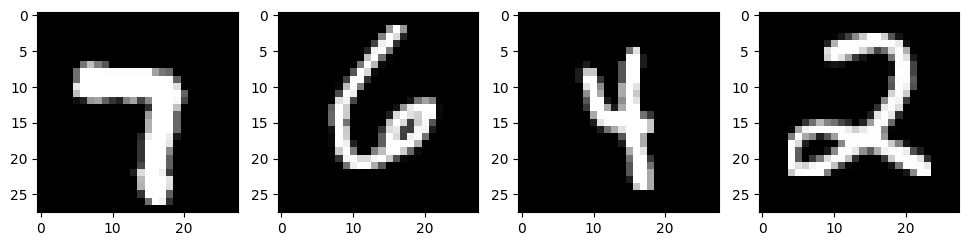

In [ ]:
# check sample image
for x, y in train_dl:
    print(x.shape, y.shape)
    break

num = 4
img = x[:num]

plt.figure(figsize=(15,15))
for i in range(num):
    plt.subplot(1,num+1,i+1)
    plt.imshow(to_pil_image(0.1307*img[i]+0.3081), cmap='gray')

In [ ]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)

    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x,p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x,p=0.8)
        x = self.fc3(x)
        return x

In [ ]:
# check
x = torch.randn(16,1,28,28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output.shape)

torch.Size([16, 10])


In [ ]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

teacher.apply(initialize_weights);

In [ ]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [ ]:
# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# set hyper parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [ ]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

## Try it!


### Design the architecutre of Student!
아래 코드 Student는 Teacher와 같은 architecture를 가지고 있습니다.

아래 코드를 수정하여, Student의 architecture 크기를 줄여보세요.

* (Teacher보다 성능이 많이 떨어지지 않는 한도 내에서,) 사이즈가 최대한 줄여보세요.

In [ ]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)

    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x,p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x,p=0.8)
        x = self.fc3(x)
        return x

In [ ]:
# check
x = torch.randn(16,1,28,28).to(device)
student = Student().to(device)
output = student(x)
print(output.shape)

torch.Size([16, 10])


In [ ]:
# weight initialization
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

student.apply(initialize_weights);

In [ ]:
teacher = Teacher().to(device)
# load weight
teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

student = Student().to(device)

# optimizer
opt = optim.Adam(student.parameters())

In [ ]:
# knowledge distillation loss
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [ ]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt, temperature=20.0):
    loss_b = loss_fn(output, target, teacher_output, T=temperature, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

### Analysis the effect of temperature
temperature의 영향을 분석하세요.
temperature의 변화에 따라, 학습 경향성이 달라집니다.

In [ ]:
num_epochs= 100 # 초반 경향성만 보려면 epoch을 줄여서 사용하세요.
temperature = 1.0 # Blank # 1.0 은 예시입니다. 바꿔서 사용하세요.

In [ ]:
loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt, temperature=temperature)
        running_loss += loss_b
        running_metric += metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

In [ ]:
# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()